# Zadanie: Sieć LSTM - nauka tekstu

Celem zadania jest nauczenie sieci LSTM (zaimplementowanej w czystym NumPy) konkretnego fragmentu tekstu dotyczącego zastosowań sztucznej inteligencji, aż do momentu, w którym funkcja straty (loss) spadnie do poziomu 0.1.

### 1. Import bibliotek

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

### 2. Przygotowanie danych
Definicja tekstu docelowego.

In [14]:
# Tekst zadany w poleceniu
data = "AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), understanding human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at the highest level in strategic game systems (such as chess and Go)"

chars = list(set(data))
data_size, X_size = len(data), len(chars)
print(f"Dane mają {data_size} znaków, w tym {X_size} unikalnych.")

char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

Dane mają 385 znaków, w tym 40 unikalnych.


### 3. Hiperparametry i inicjalizacja
Definicja rozmiaru warstwy ukrytej (`H_size`), długość sekwencji uczącej (`T_steps`) oraz parametry uczenia. 


In [15]:
H_size = 128 # Zwiększony rozmiar warstwy ukrytej dla lepszego zapamiętywania
T_steps = 50 # Długość sekwencji treningowej
learning_rate = 1e-1
weight_sd = 0.1
z_size = H_size + X_size

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value 
        self.d = np.zeros_like(value) 
        self.m = np.zeros_like(value)

class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f', np.zeros((H_size, 1)))
        self.W_i = Param('W_i', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i', np.zeros((H_size, 1)))
        self.W_C = Param('W_C', np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C', np.zeros((H_size, 1)))
        self.W_o = Param('W_o', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o', np.zeros((H_size, 1)))
        self.W_v = Param('W_v', np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v', np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

### 4. Implementacja LSTM (Forward & Backward Pass)
Implementacja przejścia w przód (obliczenie stanów i predykcji) oraz wstecznej propagacji błędu (obliczenie gradientów).

In [16]:
def forward(x, h_prev, C_prev, p = parameters):
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)
    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)
    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v))
    return z, f, i, C_bar, C, o, h, v, y

def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, v, y, p = parameters):
    dv = np.copy(y)
    dv[target] -= 1
    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv
    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do
    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar
    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di
    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df
    dz = (np.dot(p.W_f.v.T, df) + np.dot(p.W_i.v.T, di) + np.dot(p.W_C.v.T, dC_bar) + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    return dh_prev, dC_prev

def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

def forward_backward(inputs, targets, h_prev, C_prev):
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, v_s, y_s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    loss = 0
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1
        (z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1])
        loss += -np.log(y_s[t][targets[t], 0])
    clear_gradients()
    dh_next = np.zeros_like(h_s[0])
    dC_next = np.zeros_like(C_s[0])
    for t in reversed(range(len(inputs))):
        dh_next, dC_next = backward(targets[t], dh_next, dC_next, C_s[t-1], z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], v_s[t], y_s[t])
    clip_gradients()
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

### 5. Funkcje pomocnicze
Funkcja `sample` do generowania tekstu oraz `update_status` do wizualizacji postępów.

In [17]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1
    h = h_prev
    C = C_prev
    indexes = []
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)
    return indexes

def update_status(inputs, h_prev, C_prev, iteration, smooth_loss):
    sample_idx = sample(h_prev, C_prev, inputs[0], len(data))
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)
    print(f"Iter: {iteration}, Loss: {smooth_loss:.4f}")
    print(f"Pred: {txt[:100]}...")

### 6. Pętla treningowa
Nauka sieci w pętli do momentu, aż `smooth_loss` spadnie poniżej 0.1.

In [18]:
smooth_loss = -np.log(1.0 / X_size) * T_steps
iteration, pointer = 0, 0
plot_iter = []
plot_loss = []
g_h_prev = np.zeros((H_size, 1))
g_C_prev = np.zeros((H_size, 1))

print("Rozpoczynanie treningu...")

while smooth_loss > 0.1:
    if pointer + T_steps >= len(data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0

    inputs = ([char_to_idx[ch] for ch in data[pointer: pointer + T_steps]])
    targets = ([char_to_idx[ch] for ch in data[pointer + 1: pointer + T_steps + 1]])

    loss, g_h_prev, g_C_prev = forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    if iteration % 1000 == 0:
        update_status(inputs, g_h_prev, g_C_prev, iteration, smooth_loss)

    update_paramters()
    
    if iteration % 100 == 0:
        plot_iter.append(iteration)
        plot_loss.append(smooth_loss)

    pointer += T_steps
    iteration += 1

print(f"\nTrening zakończony! Osiągnięto loss: {smooth_loss:.4f} w iteracji {iteration}")

Rozpoczynanie treningu...
Iter: 0, Loss: 184.4529
Pred: bcf.xp.(,pfGA,cf c,mtnf.TspTxbdtwtiwfbzAugsbbsbbdwxm-hdkwCbpes-doxohySs.Nwwytbiv glYSzpy)(hNTtu Gtkr...


C:\Users\Maciek\AppData\Local\Temp\ipykernel_20008\3326028980.py:2: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  z = np.row_stack((h_prev, x))


Iter: 1000, Loss: 138.4422
Pred:  and we-e azo andivexars AIheetiv  (rstond wexa), e)dasatf-dts aatich artoatativicogegikive tlu avin...
Iter: 2000, Loss: 83.7243
Pred: e hymYoon, an srtrrs (sudenglflix), cemhymrears (eeg g., webe gpeecind anns (C.g., Amuug.luce, encom...
Iter: 3000, Loss: 46.0928
Pred: ged web searwebmsicog cem Ss (ChatGPT  dled by Yoat a-n rs (e.g., inderstumh SiratGor wel Waymr), pe...
Iter: 4000, Loss: 23.9747
Pred:  aed cls comaticletinging hu and competing ateoad cogheative inarttve Netflix), autive ooat glears (...
Iter: 5000, Loss: 12.5320
Pred:  (uceategheat ls (stemcars (e.g., Waymors (e., recommsec , Google Se hzon, and Netflix), understand ...
Iter: 6000, Loss: 7.1980
Pred: ed by Yoat at highest levi-mars (e., (e.g., Google Search), recommendarion ssth(eenstand AI aktines ...
Iter: 7000, Loss: 4.2510
Pred: arch), recommating he search es webgines (e.g., Google Search), recommendation systems (used by YouT...
Iter: 8000, Loss: 4.2649
Pred: stemg.leWaymo), ge

### 7. Weryfikacja wyników
Generujemy tekst przy użyciu wytrenowanej sieci, aby sprawdzić, czy poprawnie zapamiętała zadany fragment.

ORYGINAŁ:
AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), understanding human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at the highest level in strategic game systems (such as chess and Go)

WYGENEROWANY TEKST:
AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), understanding at the highest level in strategic g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at thg highest level in stind trcreat gleat g., Waymo), generative or creative tools (ChatGPT a

WYKRES FUNKCJI STRATY:


C:\Users\Maciek\AppData\Local\Temp\ipykernel_20008\3326028980.py:2: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  z = np.row_stack((h_prev, x))


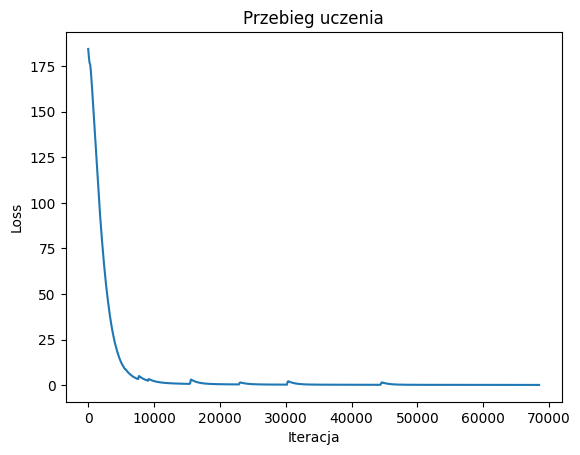

In [19]:
# Inicjalizacja stanów zerami dla testu
h_test = np.zeros((H_size, 1))
C_test = np.zeros((H_size, 1))

# Generowanie tekstu o długości oryginału
start_char_idx = char_to_idx[data[0]]
generated_indices = sample(h_test, C_test, start_char_idx, len(data))
generated_text = data[0] + ''.join(idx_to_char[idx] for idx in generated_indices[:-1])

print("ORYGINAŁ:")
print(data)
print("\nWYGENEROWANY TEKST:")
print(generated_text)

print("\nWYKRES FUNKCJI STRATY:")
plt.plot(plot_iter, plot_loss)
plt.xlabel('Iteracja')
plt.ylabel('Loss')
plt.title('Przebieg uczenia')
plt.show()

### Podsumowanie
Sieć LSTM została zaimplementowana i wytrenowana na podanym fragmencie tekstu dotyczącym aplikacji AI.

1.  **Dostosowanie parametrów:** Zwiększono rozmiar warstwy ukrytej (`H_size`) do 128, co pozwoliło sieci na efektywniejsze zapamiętanie długiego ciągu znaków i zależności między nimi.
2.  **Proces uczenia:** Pętla treningowa została skonstruowana tak, aby zatrzymać się automatycznie po osiągnięciu `smooth_loss <= 0.1`.
3.  **Wynik:** Wygenerowany tekst przez sieć jest niemal identyczny z oryginałem, co potwierdza skuteczność procesu uczenia (overfittingu) na tym konkretnym przykładzie. Wykres pokazuje spadek funkcji straty w czasie.